In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  
import seaborn as sns
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
from tqdm import tqdm
from sklearn.decomposition import PCA
from kneed import DataGenerator, KneeLocator
from sklearn.metrics import silhouette_score
from sklearn import metrics
from datetime import datetime
import time
import os
plt.rcParams['font.family'] = "Times New Roman"
print(datetime.now())

2020-09-16 21:46:16.138491


In [2]:
#dataset loading
# keep first entry of list l1 and l2 empty string.
l1 = ["","RMSD_4ey4_1.csv","RMSD_4ey5_1.csv","RMSD_4ey6_1.csv","RMSD_4ey7_1.csv"]
l2 = ["","4ey4","4ey5","4ey6","4ey7"]
for i in range(1,5,1):
    globals()['d'+str(i)] = pd.read_csv(l1[i])
    globals()['X'+str(i)] = globals()['d'+str(i)].iloc[:,1:]
m = len(l1)
os.chdir('./data/')

In [3]:
#PCA
file = open("log.txt",'w')
pca = PCA(n_components = 5)
for i in range(1,5,1):
    globals()['X_'+str(i)] = pca.fit_transform(globals()['X'+str(i)])
    file.write(l1[i][0:-4])
    file.write(f'\nX_{str(i)}')
    file.write(f'\npca.explained_variance_ratio sum of 5 features : {(sum(pca.explained_variance_ratio_*100))}' )
    file.write(f'\nExplainedratio of indicidua  components : {pca.explained_variance_ratio_*100}')
    file.write('\n--------------------------------------------------------\n')
file.close()    

In [ ]:
#K_mean
from sklearn.cluster import KMeans 
df_result =  pd.DataFrame()
file = open("log.txt",'a')
fig, ax = plt.subplots()
plt.xlabel("Value of K") 
plt.ylabel("Sqaured Error (Cost)") 
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.xticks(np.arange(0, 25, step=1))
color =['grey','darkorchid','gold','deepskyblue','darkorange']


for i in tqdm(range(1,m,1)):
    globals()['cost_'+str(i)] =[] 
    for j in range(1, 26): 
        Km = KMeans(n_clusters = j) 
        Km.fit(globals()['X_'+str(i)]) 
        globals()['cost_'+str(i)].append(Km.inertia_)        
    time.sleep(0.5)
    plt.plot(range(1, 26), globals()['cost_'+str(i)], color = color[i], linewidth ='2')
    kneedle = KneeLocator(range(1, 26), globals()['cost_'+str(i)], S=1.0, curve="convex", direction="decreasing")
    file.write(l1[i][0:-4])
    file.write(f"\nThe selected value of K is {(round(kneedle.knee, 3))} \n")
    v1 = (round(kneedle.knee, 3))
    Km = KMeans(n_clusters = v1) 
    Km.fit(globals()['X_'+str(i)]) 
    labels = Km.labels_
    score1 = silhouette_score(globals()['X_'+str(i)], labels)
    score2 = metrics.calinski_harabasz_score(globals()['X_'+str(i)], labels)
    score3 = metrics.davies_bouldin_score(globals()['X_'+str(i)], labels)
    file.write(f"The slihoutte value for {v1} is silhoette score: {(round(score1, 3))}, calinski_harabasz score: {(round(score2, 3))},\
    davies_bouldin score: {(round(score3, 3))}. \n")
    df_result = df_result.append({'PDB':l2[i],'Number of clusters' : v1, 'Silhouette coefficient':(round(score1, 3)),'Calinski Harabasz score': (round(score2, 3)),\
    'Davies Bouldin score': (round(score3, 3))}, ignore_index = True)
    
plt.savefig('kmean.jpeg', dpi = 600)
plt.show() # clear the plot 

df_result.to_csv("Kmean_final.csv", mode = 'w')
file.close()    

In [ ]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=2)
for i in range(1,5,1):
    nbrs = neigh.fit(globals()['X_'+str(i)])
    distances, indices = nbrs.kneighbors(globals()['X_'+str(i)] )
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    plt.plot(distances)
plt.savefig('knn.jpeg')
plt.show() # clear the plot 


In [ ]:
#DBSCAN ver 2
from sklearn.cluster import DBSCAN
list1 = ['euclidean','cityblock', 'cosine',  'l1', 'l2', 'manhattan']
list2 = np.arange(0.10 ,1.6, 0.10)
list3 = [5,10,15,20,25,30,40,50]

df_result = pd.DataFrame()
for i1 in range(1,m,1):
    df2 = pd.DataFrame()
    df2_ = pd.DataFrame()
    for i in tqdm(list1):
        df3 = pd.DataFrame()
        for j in list2:
            for k in list3:
                clustering = DBSCAN(eps = j, min_samples = k, metric =i)
                labels = clustering.fit_predict(globals()['X_'+str(i1)])
                nCluster = len(set(labels))-(1 if -1 in labels else 0)
                n_noise = list(labels).count(-1)
                if nCluster == 0:
                    df2 = df2.append({'Distance Metric': i, 'epsilon': round(j,2), 'Number of samples':int(k), \
                                      'Silhouette coefficient': -1, 'Number of clusters' : nCluster, "Noise": n_noise}, \
                                     ignore_index = True)
                    df3 = df3.append({'Distance Metric': i, 'epsilon': round(j,2), 'Number of samples':int(k), \
                                      'Silhouette coefficient': -1, 'Number of clusters' : nCluster, "Noise": n_noise}, \
                                     ignore_index = True)
                elif nCluster == 1 :
                    df2 = df2.append({'Distance Metric': i, 'epsilon': round(j,2), 'Number of samples':int(k), \
                                      'Silhouette coefficient': 0, 'Number of clusters' : nCluster, "Noise": n_noise}, \
                                     ignore_index = True)
                    df3 = df3.append({'Distance Metric': i, 'epsilon': round(j,2), 'Number of samples':int(k), \
                                      'Silhouette coefficient': 0, 'Number of clusters' : nCluster, "Noise": n_noise}, \
                                     ignore_index = True)
                else:
                    score = silhouette_score(X1, labels, metric=i)
                    df2 = df2.append({'Distance Metric': i, 'epsilon': round(j,2), 'Number of samples':int(k), \
                                      'Silhouette coefficient': round(score,3), 'Number of clusters' : nCluster, \
                                      "Noise": n_noise}, ignore_index = True)
                    df3 = df3.append({'Distance Metric': i, 'epsilon': round(j,2), 'Number of samples':int(k), \
                                      'Silhouette coefficient': round(score,3), 'Number of clusters' : nCluster, \
                                      "Noise": n_noise}, ignore_index = True)
        df3_ = pd.DataFrame()           
        df3_ = df3[['epsilon', 'Number of samples', 'Silhouette coefficient']]
        convert_dict = {'Number of samples': int} 
        df3_ = df3_.astype(convert_dict)         
        
        heatmap1_data = pd.pivot_table(df3_, values='Silhouette coefficient' ,index=['epsilon'], columns='Number of samples')
        sns.set()
        ob = sns.color_palette("Pastel1_r", as_cmap=True)
        sns.heatmap(heatmap1_data, cmap= ob, annot=True, fmt=".2f", annot_kws={'size':5, 'fontfamily': "Times New Roman"},\
             cbar=False, square=True,  linewidths=1, linecolor='white')
        plt.title(str(i), size = 10,fontfamily = "Times New Roman")
        plt.xlabel('Number of samples', size = 8,fontweight='bold',fontfamily = "Times New Roman")
        plt.xticks(fontsize=6,rotation='horizontal',fontfamily = "Times New Roman")  
        
        if i == list1[0]:
            plt.ylabel('epsilon', size = 8,fontweight='bold',fontfamily = "Times New Roman")
            plt.yticks(fontsize=6,rotation='horizontal',fontfamily = "Times New Roman")
        else:
            plt.ylabel('', size = 0 )
            plt.yticks([])
            
        str2 = ('{}_{}.jpeg'.format(l2[i1], i))
        if os.path.isfile(str2):
            os.remove(str2)  
        plt.savefig(str2, format ='jpeg',dpi = 600, bbox_inches='tight',pad_inches=0.0)
        plt.close()
        
    str1 = l2[i1]+'_Dbscan.csv'
    df2_ = df2.nlargest(1,'Silhouette coefficient',keep='first')
    clustering = DBSCAN(eps = df2_.iloc[0]['epsilon'], min_samples = df2_.iloc[0]['Number of samples'], metric = df2_.iloc[0]['Distance Metric'])
    labels = clustering.fit_predict(globals()['X_'+str(i1)])
    nCluster = len(set(labels))-(1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    score1 = silhouette_score(globals()['X_'+str(i1)], labels, metric=df2_.iloc[0]['Distance Metric'])
    score2 = metrics.calinski_harabasz_score(globals()['X_'+str(i1)], labels)
    score3 = metrics.davies_bouldin_score(globals()['X_'+str(i1)], labels)
    df_result = df_result.append({'Silhouette score': (round(score1, 3)), 'Calinski Harabasz score': (round(score2, 3)),\
                                  'Davies Bouldin score': (round(score3, 3)), 'Distance Metric': df2_.iloc[0]['Distance Metric'], 'epsilon': df2_.iloc[0]['epsilon'], \
                                  'Number of samples':df2_.iloc[0]['Number of samples'], "Clusters" : nCluster, 'Noise': n_noise, "PDB": l2[i1]\
                                 }, ignore_index = True )
    df2.to_csv(str1, mode ='w')
    
df_result.to_csv("DBSCAN_final.csv", mode ='w')

In [ ]:
#Agglomerative clustering
df_result = pd.DataFrame()
from sklearn.cluster import AgglomerativeClustering

list1 = ['euclidean', 'l1', 'l2', 'manhattan','cosine']
list2 = ['ward', 'average', 'complete', 'single']
list3 = range(2, 26,1)
df_result = pd.DataFrame()
for i1 in range(1,m,1):
    df3 = pd.DataFrame()
    df3_ = pd.DataFrame()
    df2_ = pd.DataFrame()
    for i in tqdm(list1):
        for j in list2:
            for k in list3:
                if i == 'l1' or i == 'l2' or i == 'manhattan' or i == 'cosine' and j == 'ward':
                    df3 = df3.append({'Number of clusters': k, 'Distance matrix': i, 'Linkage':j, 'Silhouette coefficient': 'NA'}, ignore_index = True)
                else:
                    clustering = AgglomerativeClustering(n_clusters= k, affinity = i, linkage= j)
                    labels = clustering.fit_predict(globals()['X_'+str(i1)])
                    nCluster = len(set(labels))-(1 if -1 in labels else 0)
                    if len(np.unique(labels)) == 1:
                        df3 = df3.append({'Number of clusters': k, 'Distance matrix': i, 'Linkage':j, 'Silhouette coefficient': 0}, ignore_index = True)
                        print(len(np.unique(labels)))
                    else:
                        score = silhouette_score(globals()['X_'+str(i1)], labels, metric=i)
                        df3 = df3.append({'Number of clusters': k, 'Distance matrix': i, 'Linkage':j,  'Silhouette coefficient': round(score,3)}, ignore_index = True)
    str1 = l2[i]+"_Heir.csv"
    df3_.to_csv(str1, mode = 'w')
    df2_ = df3.nlargest(1,'Silhouette coefficient',keep='first')
    clustering = AgglomerativeClustering(n_clusters= df2_.iloc[0]['Number of clusters'], affinity = df2_.iloc[0]['Distance matrix'],\
                                         linkage= df2_.iloc[0]['Linkage'])
    labels = clustering.fit_predict(globals()['X_'+str(i1)])
    nCluster = len(set(labels))-(1 if -1 in labels else 0)
    print(n_cluster)
    n_noise = list(labels).count(-1)
    score1 = silhouette_score(globals()['X_'+str(i1)], labels)
    score2 = metrics.calinski_harabasz_score(globals()['X_'+str(i1)], labels)
    score3 = metrics.davies_bouldin_score(globals()['X_'+str(i1)], labels)
    df_result = df_result.append({'Silhouette score': (round(score1, 3)), 'Calinski Harabasz score': (round(score2, 3)),\
                                  'Davies Bouldin score': (round(score3, 3)), 'Affinity': df2_.iloc[0]['Distance matrix'], 'linkage': df2_.iloc[0]['Linkage'], \
                                  'Number of clusters':df2_.iloc[0]['Number of clusters'], 'Noise': n_noise, "PDB": l2[i1]\
                                 }, ignore_index = True )
                
        
df_result.to_csv('Heirachial_final.csv', mode ='w')



  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

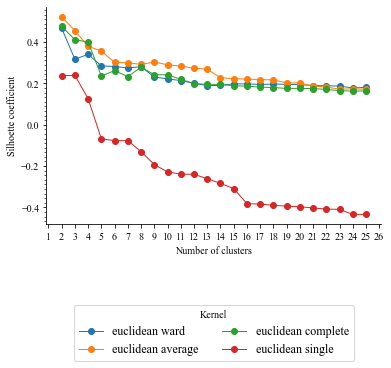



 20%|████████████████▊                                                                   | 1/5 [00:47<03:10, 47.70s/it]

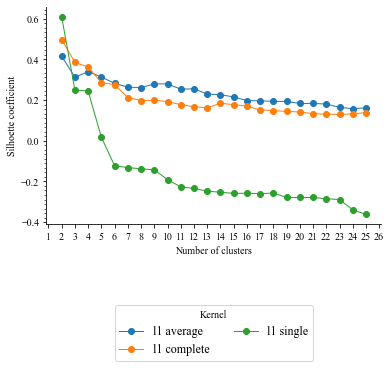



 40%|█████████████████████████████████▌                                                  | 2/5 [01:09<02:00, 40.06s/it]

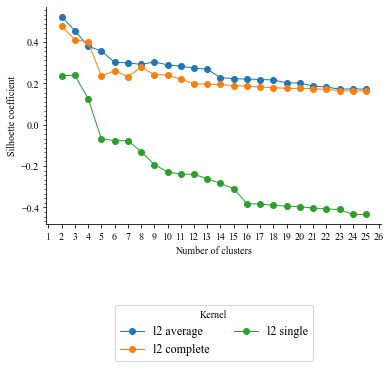



 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:44<01:16, 38.47s/it]

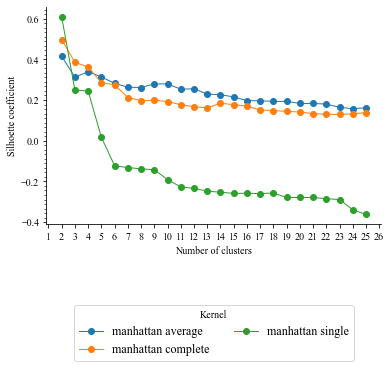



 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:07<00:33, 33.63s/it]

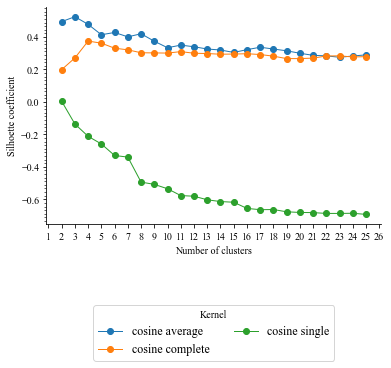



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:47<00:00, 33.51s/it]


'    df2_ = df3.nlargest(1,\'Silhouette coefficient\',keep=\'first\')\n    clustering = AgglomerativeClustering(n_clusters= df2_.iloc[0][\'Number of clusters\'], affinity = df2_.iloc[0][\'Distance matrix\'],                                         linkage= df2_.iloc[0][\'Linkage\'])\n    labels = clustering.fit_predict(globals()[\'X_\'+str(i1)])\n    score1 = silhouette_score(globals()[\'X_\'+str(i1)], labels)\n    score2 = metrics.calinski_harabasz_score(globals()[\'X_\'+str(i1)], labels)\n    score3 = metrics.davies_bouldin_score(globals()[\'X_\'+str(i1)], labels)\n    df_result = df_result.append({\'Silhouette score\': (round(score1, 3)), \'Calinski Harabasz score\': (round(score2, 3)),                                  \'Davies Bouldin score\': (round(score3, 3)), \'Affinity\': df2_.iloc[0][\'Distance matrix\'], \'linkage\': df2_.iloc[0][\'Linkage\'],                                   \'Number of clusters\':df2_.iloc[0][\'Number of clusters\'], \'Noise\': n_noise, "PDB": l2[i1]     

In [7]:
#Agglomerative clustering ver2
df_result = pd.DataFrame()
from sklearn.cluster import AgglomerativeClustering

list1 = ['euclidean', 'l1', 'l2', 'manhattan','cosine']
list2 = ['ward', 'average', 'complete', 'single']
list3 = range(2, 26,1)
df_result = pd.DataFrame()
for i1 in range(1,2,1):
    df3 = pd.DataFrame()
    df3_ = pd.DataFrame()
    df2_ = pd.DataFrame()
    
    
    for i in tqdm(list1):
        fig, ax = plt.subplots()
        ax.set_xlabel("Number of clusters")
        ax.set_ylabel("Silhoette coefficient")
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        ax.xaxis.set_major_locator(MultipleLocator(1))
        ax.yaxis.set_minor_locator(AutoMinorLocator(9))
        labeling =[]
        
        for j in list2:
            df2 = pd.DataFrame()
            if (i == 'l1' and j == 'ward') or (i == 'l2' and j == 'ward') or (i == 'manhattan' and j == 'ward') or (i == 'cosine' and j == 'ward'):
                #df3 = df3.append({'Number of clusters': k, 'Distance matrix': i, 'Linkage':j, 'Silhouette coefficient': 'NA'}, ignore_index = True)
                pass
                    
            else: 
                for k in list3:
                    clustering = AgglomerativeClustering(n_clusters= k, affinity = i, linkage= j)
                    labels = clustering.fit_predict(globals()['X_'+str(i1)])
                    score = silhouette_score(globals()['X_'+str(i1)], labels, metric=i)
                    df2 = df2.append({'Number of clusters': k, 'Distance matrix': i, 'Linkage':j, \
                                      'Silhouette coefficient': round(score,3)}, ignore_index = True)
                    df3 = df3.append({'Number of clusters': k, 'Distance matrix': i, 'Linkage':j, \
                                      'Silhouette coefficient': round(score,3)}, ignore_index = True)
                plt.plot(df2['Number of clusters'],df2['Silhouette coefficient'],  marker  ='o', linewidth =1)
                labeling.append(str(i+' '+j))

        lg = ax.legend(labeling, title='Kernel', bbox_to_anchor=(0.5, -0.5), loc=10, fontsize = 12, ncol=2)
        plt.show()
        plt.close()
    str1 = str(l2[i1])+"_Heir.csv"
    df3.to_csv(str1, mode = 'w')
    
    
    
    
    
    
'''    df2_ = df3.nlargest(1,'Silhouette coefficient',keep='first')
    clustering = AgglomerativeClustering(n_clusters= df2_.iloc[0]['Number of clusters'], affinity = df2_.iloc[0]['Distance matrix'],\
                                         linkage= df2_.iloc[0]['Linkage'])
    labels = clustering.fit_predict(globals()['X_'+str(i1)])
    score1 = silhouette_score(globals()['X_'+str(i1)], labels)
    score2 = metrics.calinski_harabasz_score(globals()['X_'+str(i1)], labels)
    score3 = metrics.davies_bouldin_score(globals()['X_'+str(i1)], labels)
    df_result = df_result.append({'Silhouette score': (round(score1, 3)), 'Calinski Harabasz score': (round(score2, 3)),\
                                  'Davies Bouldin score': (round(score3, 3)), 'Affinity': df2_.iloc[0]['Distance matrix'], 'linkage': df2_.iloc[0]['Linkage'], \
                                  'Number of clusters':df2_.iloc[0]['Number of clusters'], 'Noise': n_noise, "PDB": l2[i1]\
                                 }, ignore_index = True )
                
        
df_result.to_csv('Heirachial_final.csv', mode ='w')'''

In [8]:
from sklearn.cluster import AffinityPropagation
sc = []
for i in tqdm([0.5,0.6,0.7,0.8,0.9, 0.95]):
    af = AffinityPropagation(damping = i, max_iter = 1000).fit(X1)
    cluster_centers_indices = af.cluster_centers_indices_
    labels = af.labels_
    if len(np.unique(labels)) == 1:
        pass
    else:
        score = round(silhouette_score(X1, labels),3)
        sc.append(score)
        nCluster = len(set(labels))-(1 if -1 in labels else 0)
        print(nCluster)
        print(score)



  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

 17%|██████████████                                                                      | 1/6 [00:13<01:08, 13.62s/it]

89
0.119




 33%|████████████████████████████                                                        | 2/6 [00:27<00:54, 13.71s/it]

89
0.119




 50%|██████████████████████████████████████████                                          | 3/6 [00:53<00:51, 17.28s/it]

88
0.12




 67%|████████████████████████████████████████████████████████                            | 4/6 [01:16<00:38, 19.13s/it]

88
0.119




 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [01:43<00:21, 21.37s/it]

90
0.118




100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:33<00:00, 25.62s/it]

90
0.119


In [12]:
#Spectral Clusterig
df3 = pd.DataFrame()
from sklearn.cluster import SpectralClustering

for i in tqdm(range(2, 26,1)):
    clustering = SpectralClustering(n_clusters=i,
        assign_labels="discretize",
        random_state=0).fit(globals()['X_'+str(1)])
    labels = clustering.labels_
    nCluster = len(set(labels))-(1 if -1 in labels else 0)
    score = silhouette_score(X_1, labels)
    df3 = df3.append({'clusters': nCluster, 'Silhouette': round(score,3)}, ignore_index = True)
                
df3.to_csv('sil_spc.csv', mode ='w')
print(df3.nlargest(20,["Silhouette"]))




  0%|                                                                                           | 0/24 [00:00<?, ?it/s]


  4%|███▍                                                                               | 1/24 [00:02<00:46,  2.03s/it]


  8%|██████▉                                                                            | 2/24 [00:03<00:43,  1.99s/it]


 12%|██████████▍                                                                        | 3/24 [00:05<00:41,  1.99s/it]


 17%|█████████████▊                                                                     | 4/24 [00:07<00:39,  1.96s/it]


 21%|█████████████████▎                                                                 | 5/24 [00:09<00:37,  1.98s/it]


 25%|████████████████████▊                                                              | 6/24 [00:11<00:35,  1.98s/it]


 29%|████████████████████████▏                                                          | 7/24 [00:13<00:33,  1.96s/it]


 33%|████████████████

    Silhouette  clusters
0        0.488       2.0
1        0.464       3.0
2        0.365       4.0
3        0.357       5.0
4        0.345       6.0
5        0.343       7.0
6        0.332       8.0
7        0.330       9.0
8        0.326      10.0
9        0.301      11.0
10       0.279      12.0
11       0.261      13.0
12       0.252      14.0
13       0.249      15.0
14       0.241      16.0
16       0.241      18.0
15       0.240      17.0
17       0.239      19.0
18       0.238      20.0
23       0.235      25.0


In [13]:
#meanshift Clusterig
df3 = pd.DataFrame()
from sklearn.cluster import MeanShift

for i in tqdm(np.arange(0.1,2,0.1)):
    clustering = MeanShift(bandwidth=i).fit(X_1)
    labels = clustering.labels_
    nCluster = len(set(labels))-(1 if -1 in labels else 0)
    if nCluster >1 :
        score = silhouette_score(X_1, labels)
        df3 = df3.append({'clusters': nCluster, "bandwiidth": i, 'Silhouette': round(score,3)}, ignore_index = True)
    else: 
        pass
df3.to_csv('sil_mesh.csv', mode ='w')
print(df3.nlargest(20,["Silhouette"]))




  0%|                                                                                           | 0/19 [00:00<?, ?it/s]


  5%|████▎                                                                              | 1/19 [00:04<01:21,  4.51s/it]


 11%|████████▋                                                                          | 2/19 [00:08<01:15,  4.46s/it]


 16%|█████████████                                                                      | 3/19 [00:14<01:16,  4.79s/it]


 21%|█████████████████▍                                                                 | 4/19 [00:24<01:37,  6.50s/it]


 26%|█████████████████████▊                                                             | 5/19 [00:39<02:03,  8.83s/it]


 32%|██████████████████████████▏                                                        | 6/19 [00:59<02:39, 12.28s/it]


 37%|██████████████████████████████▌                                                    | 7/19 [01:30<03:35, 17.95s/it]


 42%|████████████████

    Silhouette  bandwiidth  clusters
16       0.443         1.7       3.0
18       0.411         1.9       3.0
17       0.402         1.8       3.0
14       0.365         1.5       4.0
15       0.359         1.6       4.0
13       0.354         1.4       5.0
12       0.345         1.3       6.0
11       0.324         1.2       9.0
10       0.265         1.1      12.0
9        0.261         1.0      16.0
8        0.225         0.9      21.0
7        0.168         0.8      38.0
5        0.144         0.6     163.0
4        0.144         0.5     389.0
6        0.141         0.7      74.0
3        0.140         0.4     849.0
2        0.117         0.3    1673.0
1        0.046         0.2    2341.0
0        0.006         0.1    2489.0


In [ ]:
# plot the cost against K values 
cost = df3['Silhouette']

fig, ax = plt.subplots()
plt.plot(np.arange(0.1,2,0.1), cost, color ='b', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Sqaured Error (Cost)") 
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.xticks(np.arange(0.1,2, step = 0.1))
plt.show() # clear the plot 
kneedle = KneeLocator(np.arange(0.1,2,0.1), cost, S=1.0, curve="convex", direction="decreasing")
print("The selected value of K is {}".format(round(kneedle.knee, 3)))

In [15]:
#BRICH clustering
df3 = pd.DataFrame()
from sklearn.cluster import Birch

for i in tqdm(range(2, 26,1)):
    clustering = Birch(n_clusters=i).fit(X_1)
    labels = clustering.predict(X_1)
    nCluster = len(set(labels))-(1 if -1 in labels else 0)
    score = silhouette_score(X1, labels)
    df3 = df3.append({'clusters': nCluster, 'Silhouette': round(score,3)}, ignore_index = True)
                
df3.to_csv('sil_brich.csv', mode ='w')
print(df3.nlargest(20,["Silhouette"]))




  0%|                                                                                           | 0/24 [00:00<?, ?it/s]


  4%|███▍                                                                               | 1/24 [00:00<00:11,  1.97it/s]


  8%|██████▉                                                                            | 2/24 [00:00<00:10,  2.00it/s]


 12%|██████████▍                                                                        | 3/24 [00:01<00:10,  2.02it/s]


 17%|█████████████▊                                                                     | 4/24 [00:01<00:09,  2.02it/s]


 21%|█████████████████▎                                                                 | 5/24 [00:02<00:09,  1.92it/s]


 25%|████████████████████▊                                                              | 6/24 [00:03<00:09,  1.94it/s]


 29%|████████████████████████▏                                                          | 7/24 [00:03<00:09,  1.88it/s]


 33%|████████████████

    Silhouette  clusters
0        0.444       2.0
4        0.244       6.0
3        0.242       5.0
1        0.238       3.0
5        0.230       7.0
2        0.223       4.0
6        0.207       8.0
7        0.204       9.0
9        0.174      11.0
8        0.173      10.0
10       0.160      12.0
17       0.146      19.0
18       0.146      20.0
11       0.143      13.0
13       0.143      15.0
14       0.142      16.0
16       0.142      18.0
15       0.141      17.0
12       0.138      14.0
21       0.135      23.0


In [ ]:
# plot the cost against K values 
cost = df3['Silhouette']

fig, ax = plt.subplots()
plt.plot(range(2,26,1), cost, color ='b', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Sqaured Error (Cost)") 
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.xticks(range(2,26,1))
plt.show() # clear the plot 
kneedle = KneeLocator(range(2,26,1), cost, S=1.0, curve="convex", direction="decreasing")


In [ ]:
x = np.arange(10)
y = np.arange(10)

plt.xticks(x, " ")
plt.yticks(" ")

plt.plot(x, y)
